In [3]:
import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = (14, 6)
from matplotlib import pyplot as plt

### Prerequisite: sampling a multivariate normal

To draw samples from a multivariate normal distribution with mean m and covariance S, we can use `np.random.multivariate_normal`. By way of example, here's a zero-mean vector and a simple covariance:





In [6]:
m = np.zeros(2)
S = np.array([[1.0, 0.9], [0.9, 1.0]])

...and here are some samples

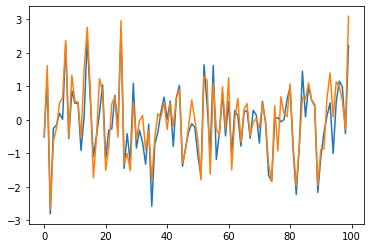

In [7]:
f = np.random.multivariate_normal(m, S, size=100)
_ = plt.plot(f)

#### Exercise 1

a) Recreate the plots from the lecture by first plotting the samples f_1, f_2 against each other, and then _next_ to each other at x_1=-1, x_2=1. `hint: you need to _slice_ the samples using f[:, 0]`

b) Show what happens when the covariance of S is increased from 0.9 to 0.99. `hint:[[1, 0.99],[0.99., 1]]`

c) What happens if we increase the covariance to 1? What's going on?

d) (harder) If we have a matrix A such that matmul(A, A.T) = S, then the following samples have covariance S: `np.matmul(A, np.random.randn(2, 100))`. Use this information to build your own multivariate_normal sampling function. `hint: what operation could we run on S to get A?`

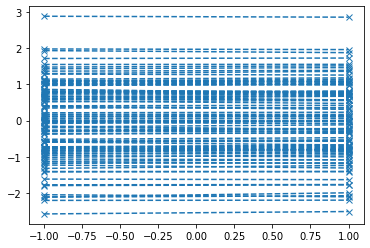

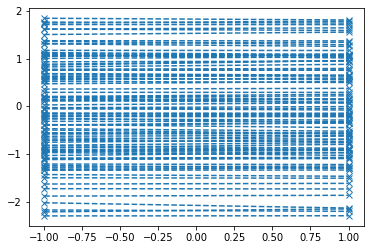

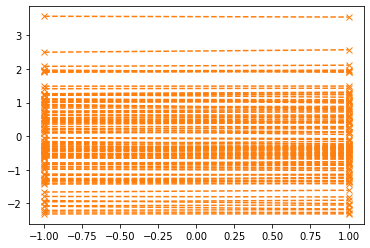

In [26]:
# a
for f_i in f:
    plt.plot([-1, 1], f_i, 'C0--', marker='x')

# b
S = np.array([[1.0, 0.999], [0.999, 1.0]])
f = np.random.multivariate_normal(m, S, size=100)
plt.figure()
for f_i in f:
    plt.plot([-1, 1], f_i, 'C0--', marker='x')
    
# c
# The lines will be completely horizontal, the matrix is singular (an eigenvalue approaches 0)

# d
def mvn_sample(mu, S, num_samples):
    D = mu.size
    epsilon = np.random.randn(num_samples, D)
    L = np.linalg.cholesky(S)
    return mu + np.dot(L, epsilon.T).T

f = mvn_sample(m, S, num_samples=100)
plt.figure()
for f_i in f:
    plt.plot([-1, 1], f_i, 'C1--', marker='x')

### Sampling a GP
To sample a Gaussian process path , we'll look at points on a fine grid. Then we need to make the covariance of the random variables dependent on the location of the grid through a kernel.

Here's a suitable grid and some helper functions.

In [27]:
xx = np.linspace(-3, 3, 50)

In [28]:
# a simple covariance function
def k(x, y):
    return np.exp(-0.5 * np.square(x - y))

# here's how to construct a kernel matrix
def build_kernel(k, X, Y):
    K = np.empty((len(X), len(Y)))
    for i in range(len(X)):
        for j in range(len(Y)):
            K[i, j] = k(X[i], Y[j])
    return K

# a simple mean function
def prior_mean(x):
    return x * 0.0

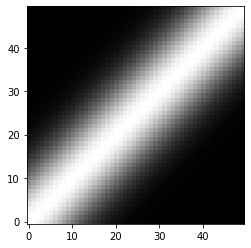

In [29]:
K = build_kernel(k, xx, xx)
_ = plt.imshow(K, cmap=plt.cm.gray, interpolation='nearest', origin='lower')

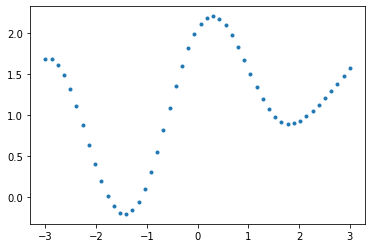

In [30]:
plt.plot(xx, np.random.multivariate_normal(prior_mean(xx), K), 'C0.')

#### Exercise 2

a) Draw some more samples and plot them!

b) Edit the kernel function to also take a variance and lengthscale parameter. Plot the effect of different lengthscales and variances. `hint: np.exp(-0.5 (x - y)**2 / l)`

c) Let's write a new kernel function that doesn't require the `build_kernel` helper. There's the outline of a class below to help you.

In [9]:
# your answers here.

class SquareExp(object):
    def __init__(self, variance, lengthscale):
        self._variance, self._lengthscale = variance, lengthscale
    
    def __call__(self, X, Y):
        # fill in this function to buikd the kernel matrix 
        # of X and Y using this class's paraemters.
        pass

### Conditioning a GP

Let's play around with conditioning a GP. Here's a helpful function that implements the equations from the lecture.

In [14]:
def conditional_gp(k, X, f_x):
    """
    Compute the mean and covariance 
    (kernel) of a GP conditioned on the points (X, f_x)
    
    The prior mean function is assumed to be mu(x) = 0.
    """
    
    def cond_mean(x):
        kxX = build_kernel(k, x, X)
        kXX = build_kernel(k, X, X)
        return np.matmul(kxX, np.linalg.solve(kXX, f_x))
    
    def cond_kernel(x, y):
        kxy = build_kernel(k, x, y)
        kxX = build_kernel(k, x, X)
        kXy = build_kernel(k, X, y)
        kXX = build_kernel(k, X, X)
        return kxy - np.matmul(kxX, np.linalg.solve(kXX, kXy))
    
    return cond_mean, cond_kernel

In [15]:
X_data = np.random.rand(3) * 6 - 3
f_data = np.random.randn(3)
mu, nu = conditional_gp(k, X_data, f_data)

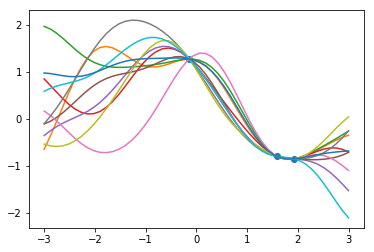

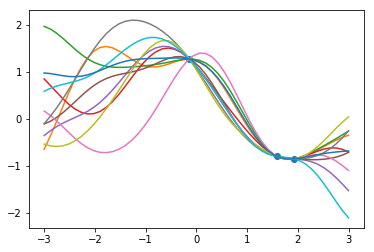

In [16]:
samples = np.random.multivariate_normal(mu(xx), nu(xx, xx), size=10)
_ = plt.plot(X_data, f_data, 'o')
_ = plt.plot(xx, samples.T)

#### Exercise 3

a) Explaing what's happening in the above plots.

b) Build a GP that is conditioned on the 'sine' data below and plot what's happening

c) Edit the conditional GP code to account for a prior mean function that is not zero. What's a better mean function for the f_sine data?

c) Reconfigure the `conditional_gp` function to use the kernel you wrote in Ex2.

d) Produce some interpolations n the 'sine' data with different settings of variance and lengthscale. Can you find a good setting of these parameters?

In [13]:
rng = np.random.RandomState(0)
x_sine = rng.rand(20) * 4 - 2
f_sine = np.sin(3 * x_sine) + np.cos(5 * x_sine)

In [ ]:
# your answers here